# Support Vector Machine (SVM) Classification

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
data = TrinaryData()
data.df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


## SVM Analysis

In [3]:
lin_clf = svm.LinearSVC()
lin_clf.fit(data.df_X, data.ser_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [4]:
predicted_class = []
for index in data.df_X.index:
     predicted = lin_clf.predict(data.df_X.loc[[index],:])[0]
     predicted_class.append(predicted)

In [5]:
predicted_class

[1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 0, 0, 0]

In [6]:
# Predicting a class
lin_clf.predict(data.df_X.loc[["T18"],:])

array([4])

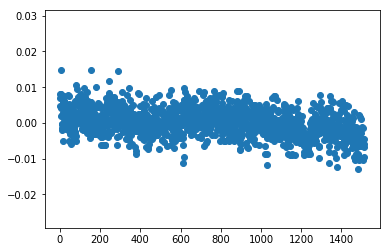

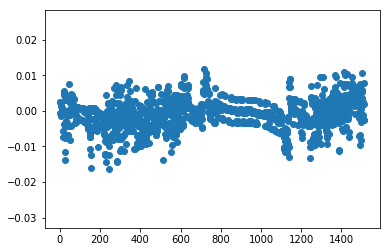

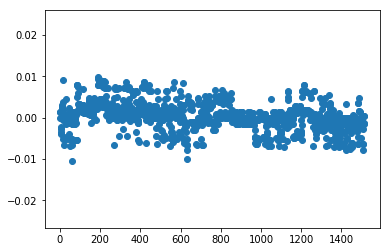

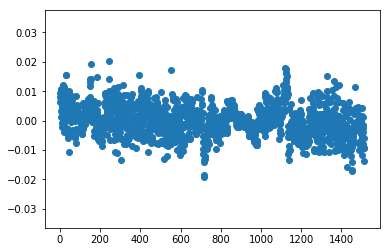

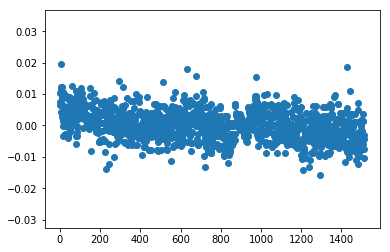

In [7]:
for n in range(5):
    plt.figure()
    plt.scatter(range(1515), lin_clf.coef_[n])

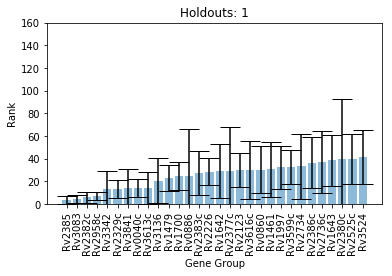

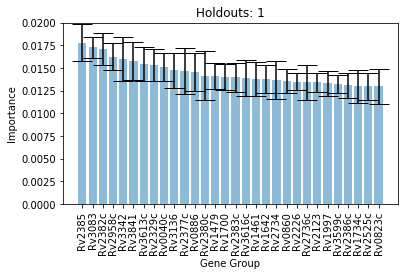

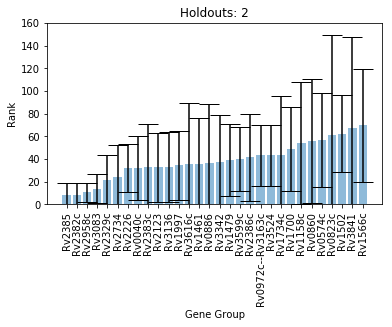

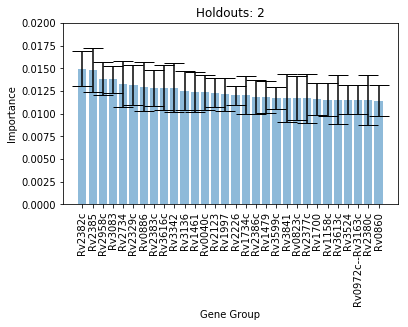

In [8]:
# Analysis of rank of gene for multiple iterations of cross validations
df_X = data.df_X.copy()
for holdouts in [1, 2]:
    df_X.columns = data.features
    result = classifier_ensemble.LinearSVMEnsemble.crossValidate(df_X, data.ser_y,
                                                                 iterations=500, holdouts=holdouts)
    result.ensemble.plotRank(top=30, title="Holdouts: %d" % holdouts, ylim=(0,160))
    result.ensemble.plotImportance(top=30, title="Holdouts: %d" % holdouts, ylim=(0, 0.02))

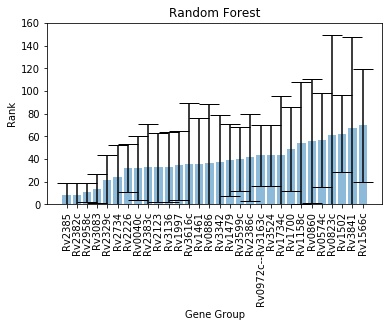

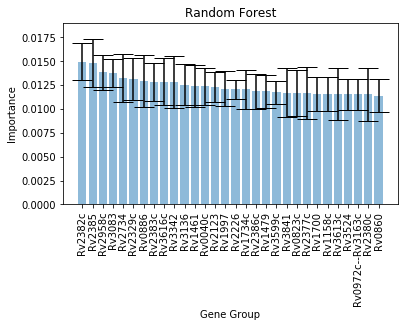

In [9]:
# Random forest
df_X = data.df_X.copy()
df_X.columns = data.features
ensemble = classifier_ensemble.RandomForestEnsemble(df_X, data.ser_y, num_iterations=20,
                        n_estimators=5000, max_features=1500, random_state=0,
                        min_samples_split=2, bootstrap=True)
result.ensemble.plotRank(top=30, title="Random Forest", ylim=(0,160))
result.ensemble.plotImportance(top=30, title="Random Forest")

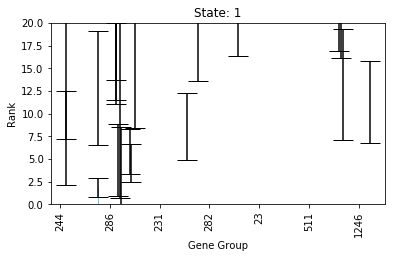

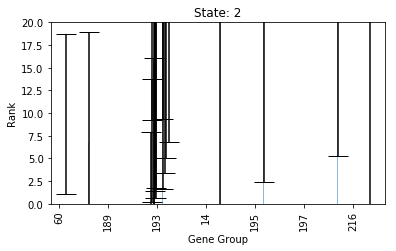

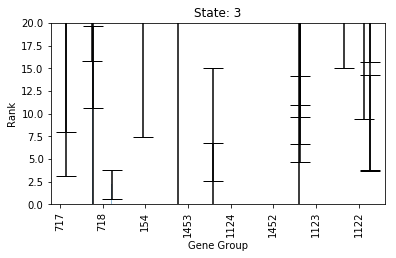

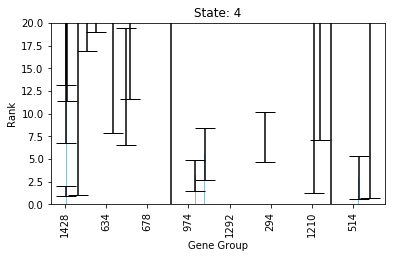

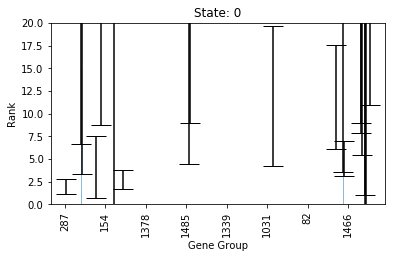

In [10]:
states = data.ser_y.unique().tolist()
holdouts = 1
result = classifier_ensemble.LinearSVMEnsemble.crossValidate(data.df_X, data.ser_y,
    classifier_args={"C": 0.5}, iterations=500, holdouts=holdouts)
for state in states:   
    result.ensemble.plotRank(class_selection=state, top=20, title="State: %d" % state, ylim=(0,20))

In [11]:
def evaluateRankFilter(high_rank,ylim=(-1,1), is_feature_columns=True):
    states = data.ser_y.unique().tolist()
    states.sort()
    df_X = data.df_X.copy()
    if is_feature_columns:
        df_X.columns = data.features
    holdouts = 1
    result = classifier_ensemble.LinearSVMEnsemble.crossValidate(df_X, data.ser_y,
        filter_high_rank=high_rank, iterations=500, holdouts=holdouts)
    print("Accuracy: %f2.4 +/- %f2.4"% (result.mean, result.std))
    for state in states:   
        result.ensemble.plotImportance(class_selection=state, top=high_rank, title="State: %d" % state, ylim=ylim)

Accuracy: 0.9712002.4 +/- 0.0702182.4


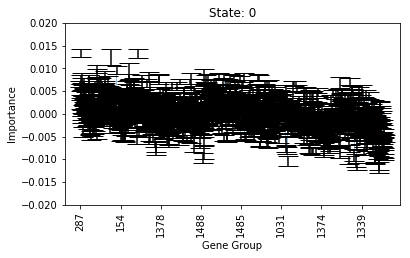

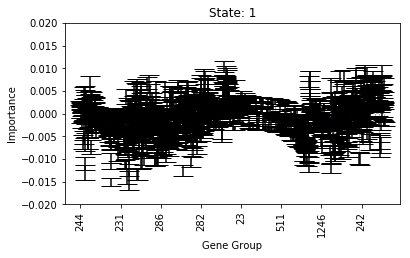

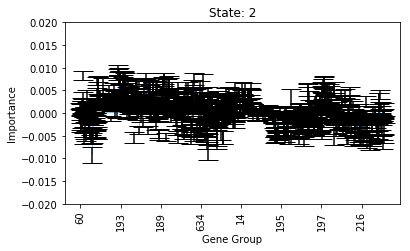

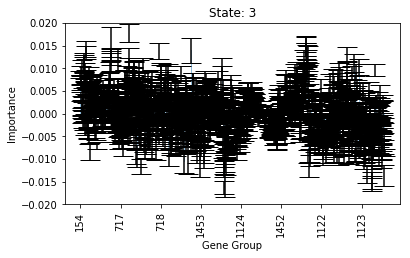

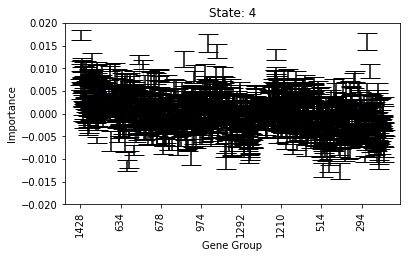

In [12]:
evaluateRankFilter(None, ylim=(-0.02, 0.02), is_feature_columns=False)

Accuracy: 0.9972002.4 +/- 0.0234982.4


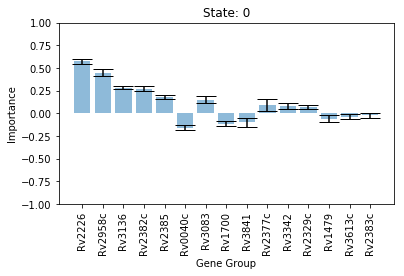

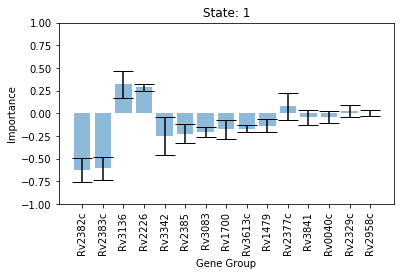

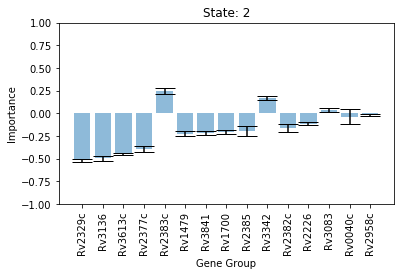

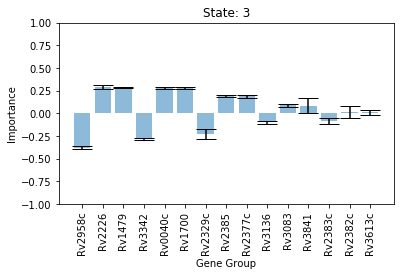

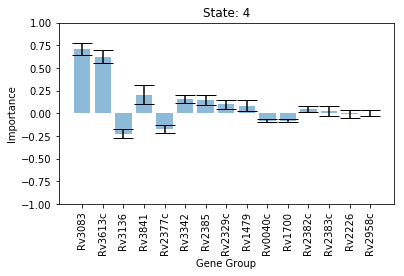

In [13]:
evaluateRankFilter(15)

In [14]:
result.mean, result.std

(0.9596, 0.0802984433223957)

**Observations**
1. Rv3574 is associated with lipid metabolism and virulence. Rv3573c is upregulated in state 2 (hypoxia). Maybe in the same regulon?
1. There are many genes that are perfectly correlated with Rv3573c.
1. Consider some kind of feature selection to reduce the number of parameters (since C regularization in SVM doesn't seem to work). Select based on rank variance for each classifier?
1. KstR, Rv3574, is key to regulation in anoxia lipid metabolism.